In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import *
from uncertainties.umath import *  # sin(), etc.
import uncertainties.umath

from uncertainties import ufloat
from uncertainties import umath
from scipy.optimize import curve_fit
import scipy as sp
sns.set_theme(style="darkgrid")
sns.set_context("paper")

## Cosine law

In [29]:
# read in data
df=pd.read_csv("LambertschesGesetz.csv")

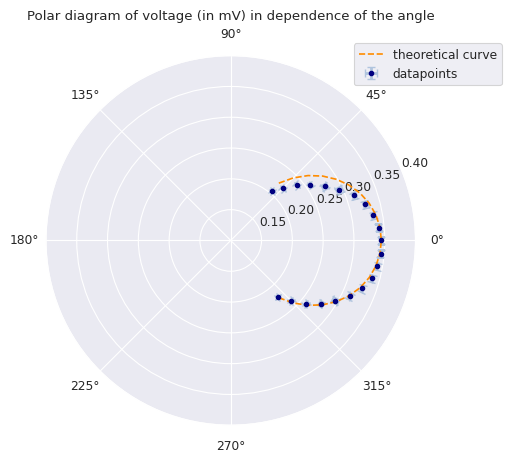

In [30]:
theta = df['Winkel'] * np.pi/180
e_theta = np.sqrt(2) * np.pi/180
r = (df['Spannung 1'] + df['Spannung 2'])/2
e_r = abs(df['Spannung 1'] - r)

plt.axes(projection='polar')
plt.title("Polar diagram of voltage (in mV) in dependence of the angle")
plt.errorbar(theta, r, xerr= e_theta, yerr=e_r, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(theta, r.max()*np.cos(theta), color = 'darkorange', ls = '--', label="theoretical curve")
plt.ylim((0.1, 0.4))
plt.legend(bbox_to_anchor=(1.25, 1.05))
plt.savefig("polarplot.png", dpi=500, bbox_inches='tight')
plt.show()

## Emitted radiation

In [31]:
# read in data, experimental parameters and constants (if needed)
df=pd.read_csv('EmittiereteStrahlung.csv')

d = ufloat(0.115, 0.0014) # distance between detector and aperture in m
r_aperture = ufloat(0.015, 0.0014) / 2 # radius of the aperture in m
r_detector = ufloat(0.032, 0.0014) / 2 # radius of the detector in m
epsilon = ufloat(30, 10) * 10**(-6) # nominal sensitivity in V

In [32]:
volt = df['Spannung'] * 10**(-3) #in V
e_volt = 0.001 * 10**(-3) #in V

volt_data = []
for i in range(len(volt)):
    volt_data.append(ufloat(volt[i],e_volt))
#volt_data

Compute from U the emitted radiation

$U = \dfrac{\epsilon E}{A_{Det}} \cdot \dfrac{A_{aperture}}{d^2} \Longrightarrow \dfrac{E}{A_{Det}} = \dfrac{U \cdot d^2}{\epsilon \cdot A_{aperture}}$

In [33]:
E_per_unit_area = (volt * d**2)/(epsilon*(r_aperture**2)*np.pi)

E_per_unit_area_nominal = np.zeros(len(E_per_unit_area))
E_per_unit_area_err = np.zeros(len(E_per_unit_area))

for i in range(len(E_per_unit_area_nominal)):
    E_per_unit_area_nominal[i] = E_per_unit_area[i].n
for i in range(len(E_per_unit_area_err)):
    E_per_unit_area_err[i] = E_per_unit_area[i].s


<ErrorbarContainer object of 3 artists>

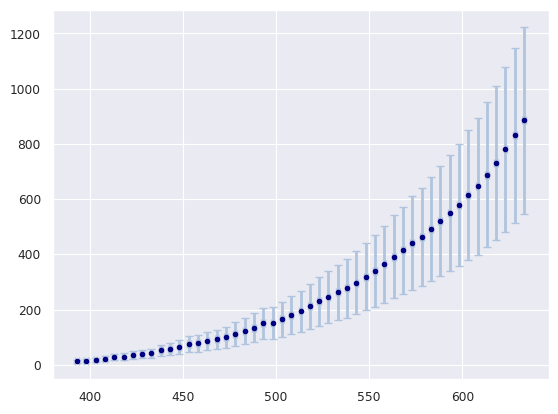

In [34]:
# plot E vs T

temp = df['Temperatur'] + 273.15 #in K
temp0 = 298.15 #room temp in K
e_temp = 1 #in K

plt.errorbar(temp, E_per_unit_area_nominal, xerr= e_temp, yerr=E_per_unit_area_err, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="Datapoints")

In [35]:
def sbl(temp, sigma):
    return sigma*(temp**4)

popt, pcov = sp.optimize.curve_fit(sbl, (temp-temp0), E_per_unit_area_nominal)#, sigma=E_per_unit_area_err)

In [36]:
print("σ = ", popt[0], "+/-", np.sqrt(pcov[0][0]))

σ =  7.294307225384827e-08 +/- 8.296458277119213e-10


In [37]:
# calculate sigma for theoretical U plot
sigma_u = popt[0] * 1/(d**2/(epsilon*(r_aperture**2)*np.pi))
sigma_u

2.9240313506237694e-14+/-1.1193670637866631e-14

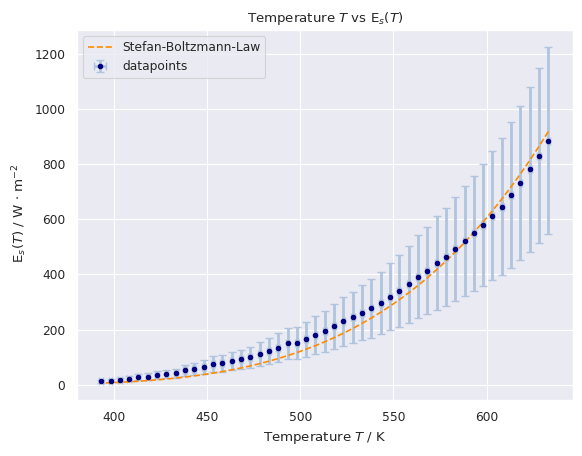

In [38]:
plt.title("Temperature $T$ vs E$_s$($T$)")
plt.errorbar(temp, E_per_unit_area_nominal, xerr= e_temp, yerr=E_per_unit_area_err, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(temp, sbl((temp-temp0), popt), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law")

plt.xlabel("Temperature $T$ / K")
plt.ylabel(" E$_s$($T$) / W $\cdot$ m$^{-2}$")

plt.legend()
plt.savefig("EvsT.png", dpi=500, bbox_inches='tight')
plt.show()

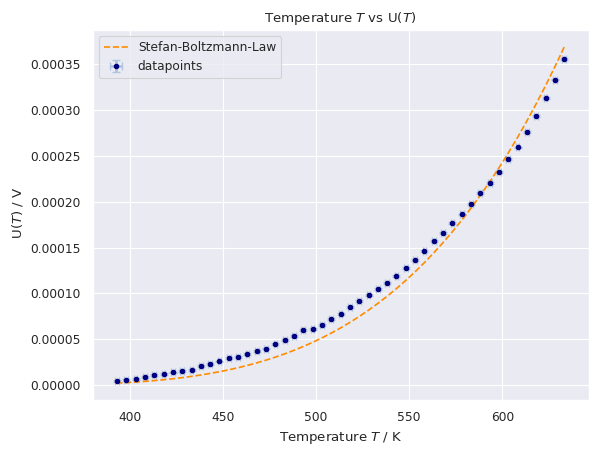

2.924031350790406e-14 3.3257584761699974e-16


In [39]:
plt.title("Temperature $T$ vs U($T$)")
plt.errorbar(temp, volt, xerr= e_temp, yerr = e_volt, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")

def sbl(temp, sigma):
    return sigma*(temp**4)

poptU, pcovU = sp.optimize.curve_fit(sbl, (temp-temp0), volt)
plt.plot(temp, sbl((temp-temp0), poptU), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law")
plt.xlabel("Temperature $T$ / K")
plt.ylabel(" U($T$) / V")

plt.legend()
plt.savefig("UT.png", dpi=500, bbox_inches='tight')
plt.show()
print(poptU[0], np.sqrt(pcovU[0][0]))

In [40]:
#def log_fit(temp, sigma):
#    return np.log10(sigma) + np.log10(temp**4 - temp0**4)

In [41]:
#popt2, pcov2 = sp.optimize.curve_fit(log_fit, temp, np.log10(E_per_unit_area_nominal))

In [42]:
#popt2

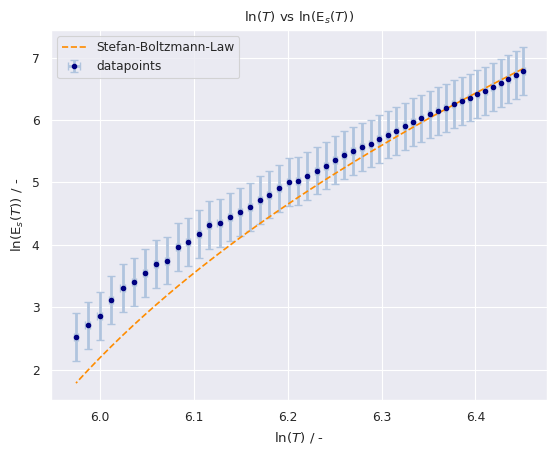

In [43]:
plt.title("ln($T$) vs ln(E$_s$($T$))")
plt.errorbar(np.log(temp), np.log(E_per_unit_area_nominal), xerr=e_temp/temp, yerr=E_per_unit_area_err/E_per_unit_area_nominal, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(np.log(temp), np.log(sbl((temp-temp0), popt)), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law")
#plt.plot(np.log10(temp), log_fit(temp, popt2), color="lightgrey", ls = '--', label="direct fit")

plt.xlabel("ln($T$) / -")
plt.ylabel("ln(E$_s$($T$)) / -")

plt.legend()
plt.savefig("logEvsT.png", dpi=500, bbox_inches='tight')
plt.show()

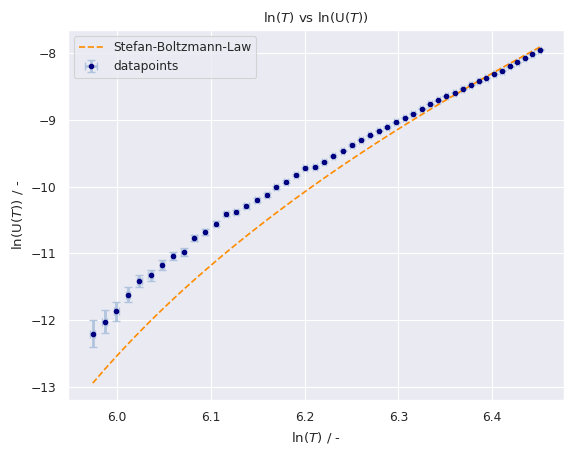

In [44]:
plt.title("ln($T$) vs ln(U($T$))")
plt.errorbar(np.log(temp), np.log(volt), xerr=e_temp/temp, yerr=e_volt/volt, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(np.log(temp), np.log(sbl((temp-temp0), poptU)), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law")
#plt.plot(np.log10(temp), log_fit(temp, popt2), color="lightgrey", ls = '--', label="direct fit")

plt.xlabel("ln($T$) / -")
plt.ylabel("ln(U($T$)) / -")

plt.legend()
plt.savefig("logUT.png", dpi=500, bbox_inches='tight')
plt.show()

In [45]:
dE_vs_dT_nominal = np.zeros(len(E_per_unit_area))
dE_vs_dT_err = np.zeros(len(E_per_unit_area))
for i in range(len(E_per_unit_area_nominal) - 1):
    dE_vs_dT_nominal[i] = (E_per_unit_area_nominal[i+1] - E_per_unit_area_nominal[i])/(temp[i+1] - temp[i])

dE_vs_dT_nominal = dE_vs_dT_nominal[dE_vs_dT_nominal != 0]

print(dE_vs_dT_nominal, len(dE_vs_dT_nominal))

[10.97626802  9.97842547  9.97842547  8.48166165  8.48166165  6.48597655
  6.98489783  5.98705528  5.48813401  5.98705528  5.48813401  4.49029146
  5.48813401  4.49029146  5.48813401  4.98921273  3.99137019  4.49029146
  3.99137019  2.99352764  3.49244891  2.99352764  3.49244891  3.49244891
  2.99352764  2.99352764  2.49460637  0.49892127  2.99352764  2.49460637
  1.99568509  2.49460637  1.49676382  1.49676382  1.49676382  0.49892127
  1.99568509  1.49676382  0.99784255  1.99568509  0.49892127  0.99784255
  0.99784255  0.49892127  0.99784255  0.99784255  0.49892127  0.49892127] 48


In [46]:
dU_vs_dT_nominal = np.zeros(len(volt))
dU_vs_dT_err = np.zeros(len(volt))
for i in range(len(volt) - 1):
    dU_vs_dT_nominal[i] = (volt[i+1] - volt[i])/(temp[i+1] - temp[i])

dU_vs_dT_nominal = dU_vs_dT_nominal[dU_vs_dT_nominal != 0]

print(dU_vs_dT_nominal, len(dU_vs_dT_nominal))

for i in range(len(volt) - 1):
    dU_vs_dT_err[i] = np.sqrt(2)/(temp[i+1] - temp[i])

dU_vs_dT_err = -dU_vs_dT_err[dU_vs_dT_err != 0]
dU_vs_dT_err

[4.4e-06 4.0e-06 4.0e-06 3.4e-06 3.4e-06 2.6e-06 2.8e-06 2.4e-06 2.2e-06
 2.4e-06 2.2e-06 1.8e-06 2.2e-06 1.8e-06 2.2e-06 2.0e-06 1.6e-06 1.8e-06
 1.6e-06 1.2e-06 1.4e-06 1.2e-06 1.4e-06 1.4e-06 1.2e-06 1.2e-06 1.0e-06
 2.0e-07 1.2e-06 1.0e-06 8.0e-07 1.0e-06 6.0e-07 6.0e-07 6.0e-07 2.0e-07
 8.0e-07 6.0e-07 4.0e-07 8.0e-07 2.0e-07 4.0e-07 4.0e-07 2.0e-07 4.0e-07
 4.0e-07 2.0e-07 2.0e-07] 48


array([0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271, 0.28284271, 0.28284271,
       0.28284271, 0.28284271, 0.28284271])

In [47]:
for i in range(len(E_per_unit_area_err) - 1):
    dE_vs_dT_err[i] = (E_per_unit_area_err[i+1] - E_per_unit_area_err[i])/(temp[i+1] - temp[i])

dE_vs_dT_err = dE_vs_dT_err[dE_vs_dT_err != 0]
dE_vs_dT_err

array([4.20189506, 3.8199046 , 3.8199046 , 3.24691891, 3.24691891,
       2.48293799, 2.67393322, 2.29194276, 2.10094753, 2.29194276,
       2.10094753, 1.71895707, 2.10094753, 1.71895707, 2.10094753,
       1.9099523 , 1.52796184, 1.71895707, 1.52796184, 1.14597138,
       1.33696661, 1.14597138, 1.33696661, 1.33696661, 1.14597138,
       1.14597138, 0.95497615, 0.19099523, 1.14597138, 0.95497615,
       0.76398092, 0.95497615, 0.57298569, 0.57298569, 0.57298569,
       0.19099523, 0.76398092, 0.57298569, 0.38199046, 0.76398092,
       0.19099523, 0.38199046, 0.38199046, 0.19099523, 0.38199046,
       0.38199046, 0.19099523, 0.19099523])

In [48]:
T_avg = np.zeros(len(dE_vs_dT_nominal))
tempcorr = temp - temp0 #correct temperature for roomtemp (otherwise axes are wrong)
for i in range(len(T_avg)):
    T_avg[i] = (tempcorr[i+1] + tempcorr[i])/2
T_avg

array([332.5, 327.5, 322.5, 317.5, 312.5, 307.5, 302.5, 297.5, 292.5,
       287.5, 282.5, 277.5, 272.5, 267.5, 262.5, 257.5, 252.5, 247.5,
       242.5, 237.5, 232.5, 227.5, 222.5, 217.5, 212.5, 207.5, 202.5,
       197.5, 192.5, 187.5, 182.5, 177.5, 172.5, 167.5, 162.5, 157.5,
       152.5, 147.5, 142.5, 137.5, 132.5, 127.5, 122.5, 117.5, 112.5,
       107.5, 102.5,  97.5])

σ =  7.770042761846975e-08 +/- 4.7871354742525446e-09


/tmp/ipykernel_279/584778328.py:5: RuntimeWarning: invalid value encountered in log
  return 3 * np.log(temp) + np.log(4*sigma)


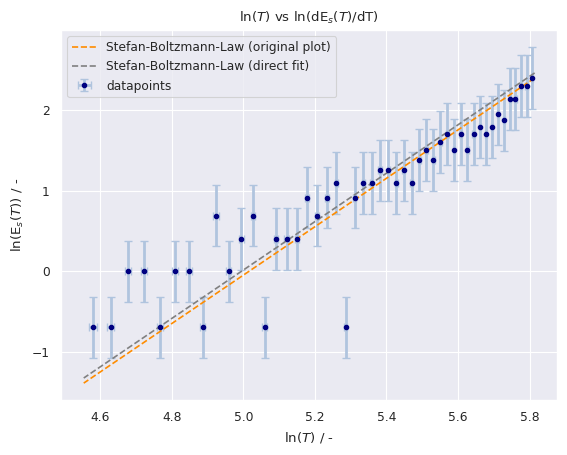

In [49]:
plt.title("ln($T$) vs ln(dE$_s$($T$)/dT)")
plt.errorbar(np.log(T_avg), np.log(dE_vs_dT_nominal), xerr=e_temp/T_avg, yerr=dE_vs_dT_err/dE_vs_dT_nominal, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")

def lin_sbl(temp, sigma):
    return 3 * np.log(temp) + np.log(4*sigma) 
popt2, pcov2 = sp.optimize.curve_fit(lin_sbl, T_avg, np.log(dE_vs_dT_nominal))
print("σ = ", popt2[0], "+/-", np.sqrt(pcov2[0][0]))

plt.plot(np.log(temp - temp0),lin_sbl((temp-temp0), popt), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law (original plot)")
plt.plot(np.log(temp - temp0),lin_sbl((temp-temp0), popt2), color="grey", ls = '--', label="Stefan-Boltzmann-Law (direct fit)")


plt.xlabel("ln($T$) / -")
plt.ylabel("ln(E$_s$($T$)) / -")

plt.legend()
plt.savefig("logdEdTvsT.png", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_279/1488114269.py:5: RuntimeWarning: invalid value encountered in log
  return 3 * np.log(temp) + np.log(4*sigma)


σ =  3.114737008046384e-14 +/- 1.918994294484065e-15


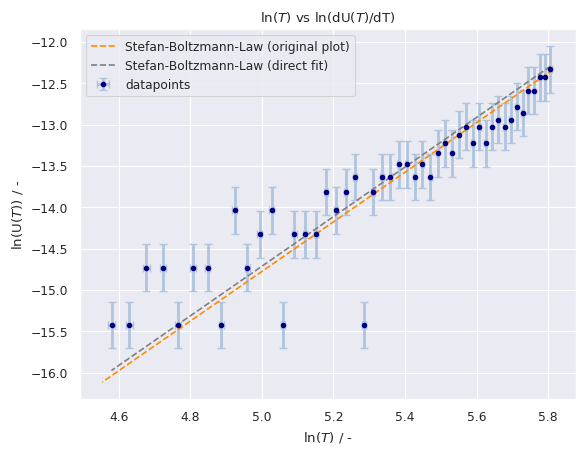

In [51]:
plt.title("ln($T$) vs ln(dU($T$)/dT)")
plt.errorbar(np.log(T_avg), np.log(dU_vs_dT_nominal), xerr=e_temp/T_avg, yerr=abs(dU_vs_dT_err), markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")

def lin_sbl(temp, sigma):
    return 3 * np.log(temp) + np.log(4*sigma) 

poptU2, pcovU2 = sp.optimize.curve_fit(lin_sbl, T_avg, np.log(dU_vs_dT_nominal))
print("σ = ", poptU2[0], "+/-", np.sqrt(pcovU2[0][0]))

plt.plot(np.log(temp - temp0),lin_sbl((temp-temp0), poptU), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law (original plot)")
plt.plot(np.log(T_avg),lin_sbl((T_avg), poptU2), color="grey", ls = '--', label="Stefan-Boltzmann-Law (direct fit)")

plt.xlabel("ln($T$) / -")
plt.ylabel("ln(U($T$)) / -")

plt.legend()
plt.savefig("logdUdTvsT.png", dpi=500, bbox_inches='tight')
plt.show()